# 7주차 스터디 

    1. MDD

    2. Efficient Frontier

    3. Momentum 퀀트 전략 구현 및 평가 (for 반목문 사용)

    4. 확률과정 (Stochastic Process)

    5. 옵션 가치평가 (몬테카를로 시뮬레이션)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [60]:
# 사용할 데이터를 불러오겠습니다
samsung = pd.read_csv("Data/삼성전자주가.csv", index_col=0, parse_dates=True)[["Close"]]
samsung

,Close
Date,
2019-01-31,46150
2019-02-01,46350
2019-02-07,46200
2019-02-08,44800
2019-02-11,45000
...,...
2022-12-23,58100
2022-12-26,57900
2022-12-27,58100


In [8]:
# Return도 계산해두겠습니다
samsung_rtn = samsung.pct_change()

## 1. MDD 

$MDD =$ $Trough - Peak \over Peak$ 

MDD(Maximum Draw Down) : 투자자가 투자기간 동안 견뎌야 하는 '고통의 최고치'를 의미

해석: 수익률이 아무리 뛰어나도, MDD가 너무 높은 전략이라면 과연 Implementable 할까?

In [16]:
# MDD 계산 (공식에 그대로 대입해주면 된다)
peak = samsung.cummax()       # cummax는 cumulative max의 줄임말
dd = (samsung - peak) / peak
dd.min() # 42%의 MDD를 기록했습니다

Close   -0.421978
dtype: float64

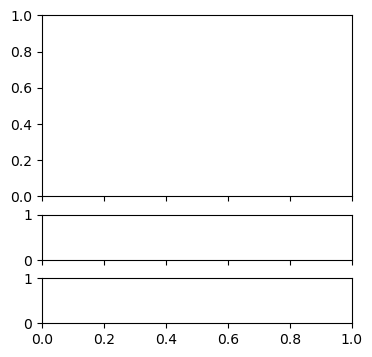

In [22]:
# 주식 수익률 보고를 위한 완전한 Plot을 그려보자

# 코드 설명
fig, axes = plt.subplots(3,1,              # (3,1)개의 axes를 생성
                         sharex=True,      # 모든 axes가 x축을 공유
                         figsize=(4,4),    # 그림이 그려지는 figure의 사이즈 설정
                         gridspec_kw={'height_ratios': [4, 1, 1]})  # 각 axes의 높이 비율을 지정

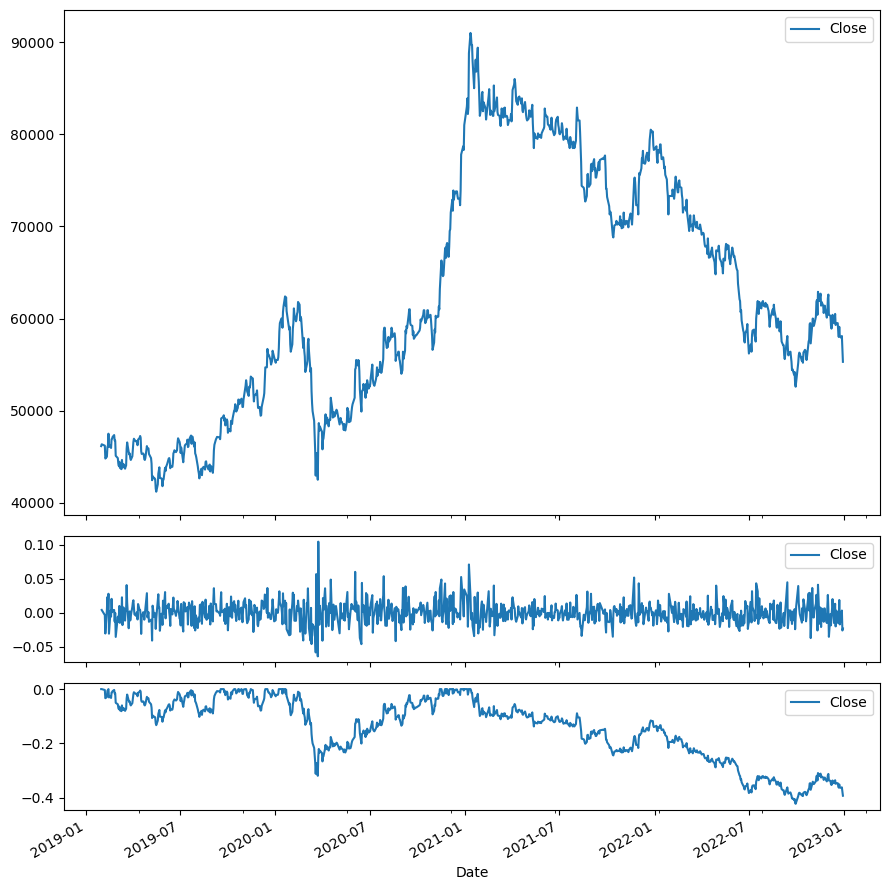

In [25]:
fig, axes = plt.subplots(3,1,              
                         sharex=True,      
                         figsize=(9,9),    
                         gridspec_kw={'height_ratios': [4, 1, 1]}) 

samsung.plot(ax=axes[0]) # 0번째 axes에 그린다
samsung_rtn.plot(ax=axes[1]) # 1번째 axes에 그린다
dd.plot(ax=axes[2])       # 2번째 axes에 그린다

plt.tight_layout();  # layout을 깔끔하게

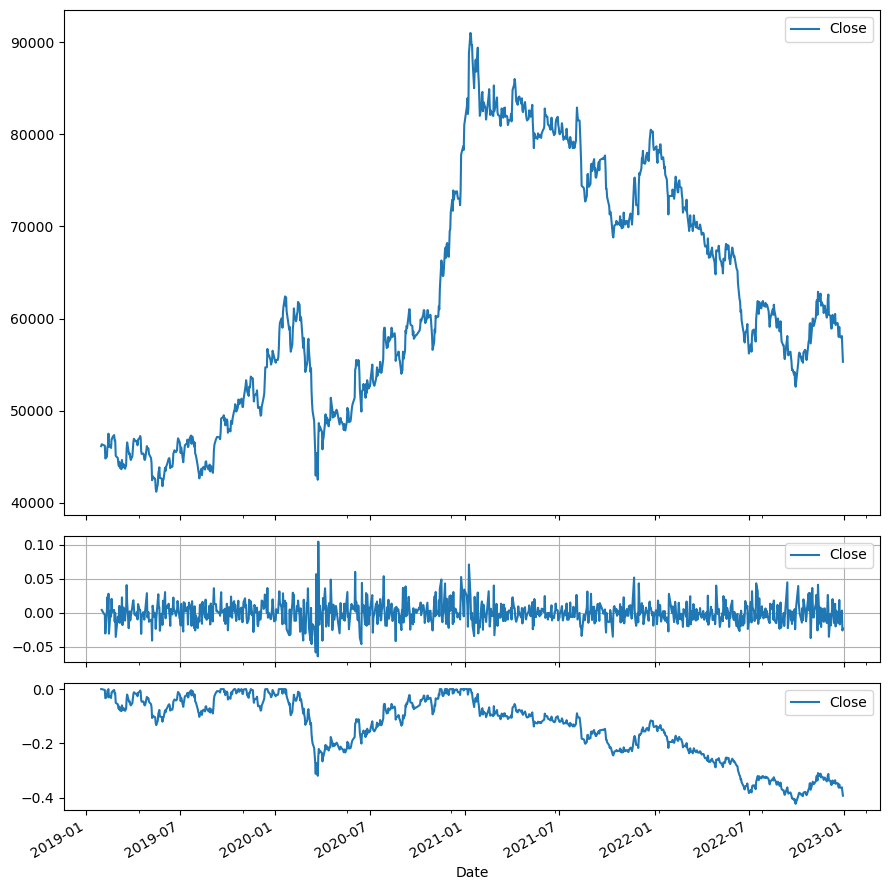

In [26]:
# 개별 axes에 grid를 추가하고 싶다면?
fig, axes = plt.subplots(3,1,              
                         sharex=True,      
                         figsize=(9,9),    
                         gridspec_kw={'height_ratios': [4, 1, 1]}) 

samsung.plot(ax=axes[0]) 
samsung_rtn.plot(ax=axes[1]) 
dd.plot(ax=axes[2])       

axes[1].grid()  # 요런식으로 해주면 된다
plt.tight_layout();  # layout을 깔끔하게

## 2. Efficient Frontier

In [28]:
# 사용할 데이터 불러오기
data = pd.read_csv("Data/Stocks_sample.csv", 
                   index_col=0,
                   parse_dates=True)
data

,HMM,삼성전자,에쓰오일,에코프로,엔씨소프트,현대차
Date,,,,,,
2018-01-02,5010,51020,117000,25698,446500,149500
2018-01-03,4790,51620,113500,24630,435000,150500
2018-01-04,4625,51080,113500,23918,422500,146500
2018-01-05,4635,52120,113000,24727,422000,149000
2018-01-08,4520,52020,111500,24144,420000,151000
...,...,...,...,...,...,...
2022-12-23,21700,58100,88000,108595,429500,157000
2022-12-26,21750,57900,89500,110926,432000,158000
2022-12-27,21850,58100,89100,111800,432000,158000


In [29]:
# 퍼센트 변화를 구한다
rtn = data.pct_change()
rtn

,HMM,삼성전자,에쓰오일,에코프로,엔씨소프트,현대차
Date,,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,-0.043912,0.011760,-0.029915,-0.041560,-0.025756,0.006689
2018-01-04,-0.034447,-0.010461,0.000000,-0.028908,-0.028736,-0.026578
2018-01-05,0.002162,0.020360,-0.004405,0.033824,-0.001183,0.017065
2018-01-08,-0.024811,-0.001919,-0.013274,-0.023577,-0.004739,0.013423
...,...,...,...,...,...,...
2022-12-23,-0.033408,-0.016920,-0.002268,-0.048506,-0.020525,-0.009464
2022-12-26,0.002304,-0.003442,0.017045,0.021465,0.005821,0.006369
2022-12-27,0.004598,0.003454,-0.004469,0.007879,0.000000,0.000000


In [33]:
# 연율화된 변동성과 리턴을 구한다
mean_return = rtn.mean() * 250
sigma = rtn.cov() * 250

In [57]:
# 생성할 난수(Random Number)의 수
n_port = 30_000

# 값을 저장할 리스트
pf_return = []
pf_sigma = []
pf_weight = []

기대수익률:  $W$ $\cdot$ $E(R)$

분산 :   $W^T$ $\cdot$ $\sum$ $\cdot$ $W$

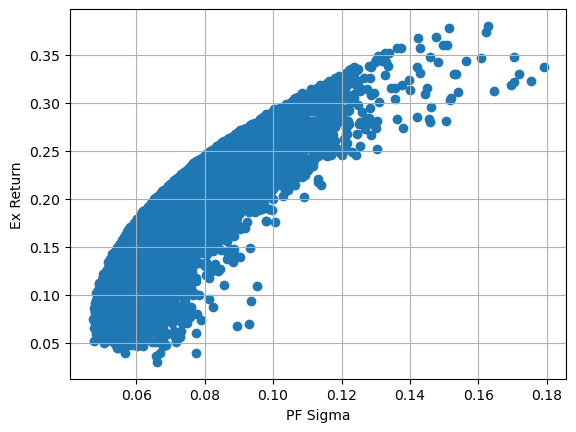

In [58]:
for _ in range(n_port):
    
    # 6개 주식의 Random한 Weight를 설정하고, 합을 1로 맞춰준다
    weight = np.random.random(6)
    weight /= np.sum(weight)
    
    pf_return.append(np.dot(weight, mean_return)) # 기대리턴
    pf_sigma.append(np.dot(weight.T, np.dot(sigma, weight))) # 분산(포트폴리오의 위험)
    pf_weight.append(weight) # 가중치 저장

plt.scatter(pf_sigma, pf_return)
plt.xlabel("PF Sigma")
plt.ylabel("Ex Return")
plt.grid();

## 3. Momentum 퀀트 전략 구현하고 평가하기

20일 이동 평균선을 돌파하면 주식을 사고, 그 반대일 때는 파는 전략을 구현해봅시다

In [61]:
# 삼성전자 주가를 사용하겠습니다 / 리턴을 컬럼에 추가
samsung["rtn"] = samsung.pct_change()
samsung

,Close,rtn
Date,,
2019-01-31,46150,NaN
2019-02-01,46350,0.004334
2019-02-07,46200,-0.003236
2019-02-08,44800,-0.030303
2019-02-11,45000,0.004464
...,...,...
2022-12-23,58100,-0.016920
2022-12-26,57900,-0.003442
2022-12-27,58100,0.003454


In [64]:
# 20일 이동평균을 데이터프레임에 추가하겠습니다
samsung["ma20"] = samsung.Close.rolling(window=20).mean()
samsung  

,Close,rtn,ma20
Date,,,
2019-01-31,46150,NaN,NaN
2019-02-01,46350,0.004334,NaN
2019-02-07,46200,-0.003236,NaN
2019-02-08,44800,-0.030303,NaN
2019-02-11,45000,0.004464,NaN
...,...,...,...
2022-12-23,58100,-0.016920,59785.0
2022-12-26,57900,-0.003442,59675.0
2022-12-27,58100,0.003454,59550.0


In [70]:
pf_value = 1  # 초기 자산
hold = False  # 현재 주식을 보유하고 있는지
pf_value_dict = {} # pf_value 기록을 위해

for date in samsung.index:
    one_day = samsung.loc[date]
    
    # hold==True일 경우, 주식 가격의 변화를 포트폴리오 가치 변화에 반영
    if hold == True:
        pf_value = pf_value * (1+one_day.rtn)  # pf_value를 업데이트
        
    # 매수(Buy)조건 : 20일 이평선을 뚫고 올라가는 경우 산다 & 지금 포지션이 없어야함
    if (one_day.Close > one_day.ma20) & (hold == False):
        hold = True
        # 주식은 pf_value만큼 전부 사게 된다(이걸 정하는 것도 전략의 일부)
    # 매도(Sell)조건 : 20일 이평선 아래로 내려오는 경우 판다 & 지금 포지션이 있어야함
    elif (one_day.Close < one_day.ma20) & (hold == True):
        hold = False
    
    # 매일매일 pf_value를 저장
    pf_value_dict[date] = pf_value

In [71]:
# 저장된 값 확인
pf_value_dict

{Timestamp('2019-01-31 00:00:00'): 1,
 Timestamp('2019-02-01 00:00:00'): 1,
 Timestamp('2019-02-07 00:00:00'): 1,
 Timestamp('2019-02-08 00:00:00'): 1,
 Timestamp('2019-02-11 00:00:00'): 1,
 Timestamp('2019-02-12 00:00:00'): 1,
 Timestamp('2019-02-13 00:00:00'): 1,
 Timestamp('2019-02-14 00:00:00'): 1,
 Timestamp('2019-02-15 00:00:00'): 1,
 Timestamp('2019-02-18 00:00:00'): 1,
 Timestamp('2019-02-19 00:00:00'): 1,
 Timestamp('2019-02-20 00:00:00'): 1,
 Timestamp('2019-02-21 00:00:00'): 1,
 Timestamp('2019-02-22 00:00:00'): 1,
 Timestamp('2019-02-25 00:00:00'): 1,
 Timestamp('2019-02-26 00:00:00'): 1,
 Timestamp('2019-02-27 00:00:00'): 1,
 Timestamp('2019-02-28 00:00:00'): 1,
 Timestamp('2019-03-04 00:00:00'): 1,
 Timestamp('2019-03-05 00:00:00'): 1,
 Timestamp('2019-03-06 00:00:00'): 1,
 Timestamp('2019-03-07 00:00:00'): 1,
 Timestamp('2019-03-08 00:00:00'): 1,
 Timestamp('2019-03-11 00:00:00'): 1,
 Timestamp('2019-03-12 00:00:00'): 1,
 Timestamp('2019-03-13 00:00:00'): 1,
 Timestamp('

In [74]:
# 딕셔너리는 시리즈로 바꾸면 보기 쉽습니다
result = pd.Series(pf_value_dict)
result

2019-01-31    1.000000
2019-02-01    1.000000
2019-02-07    1.000000
2019-02-08    1.000000
2019-02-11    1.000000
                ...   
2022-12-23    1.187335
2022-12-26    1.187335
2022-12-27    1.187335
2022-12-28    1.187335
2022-12-29    1.187335
Length: 967, dtype: float64

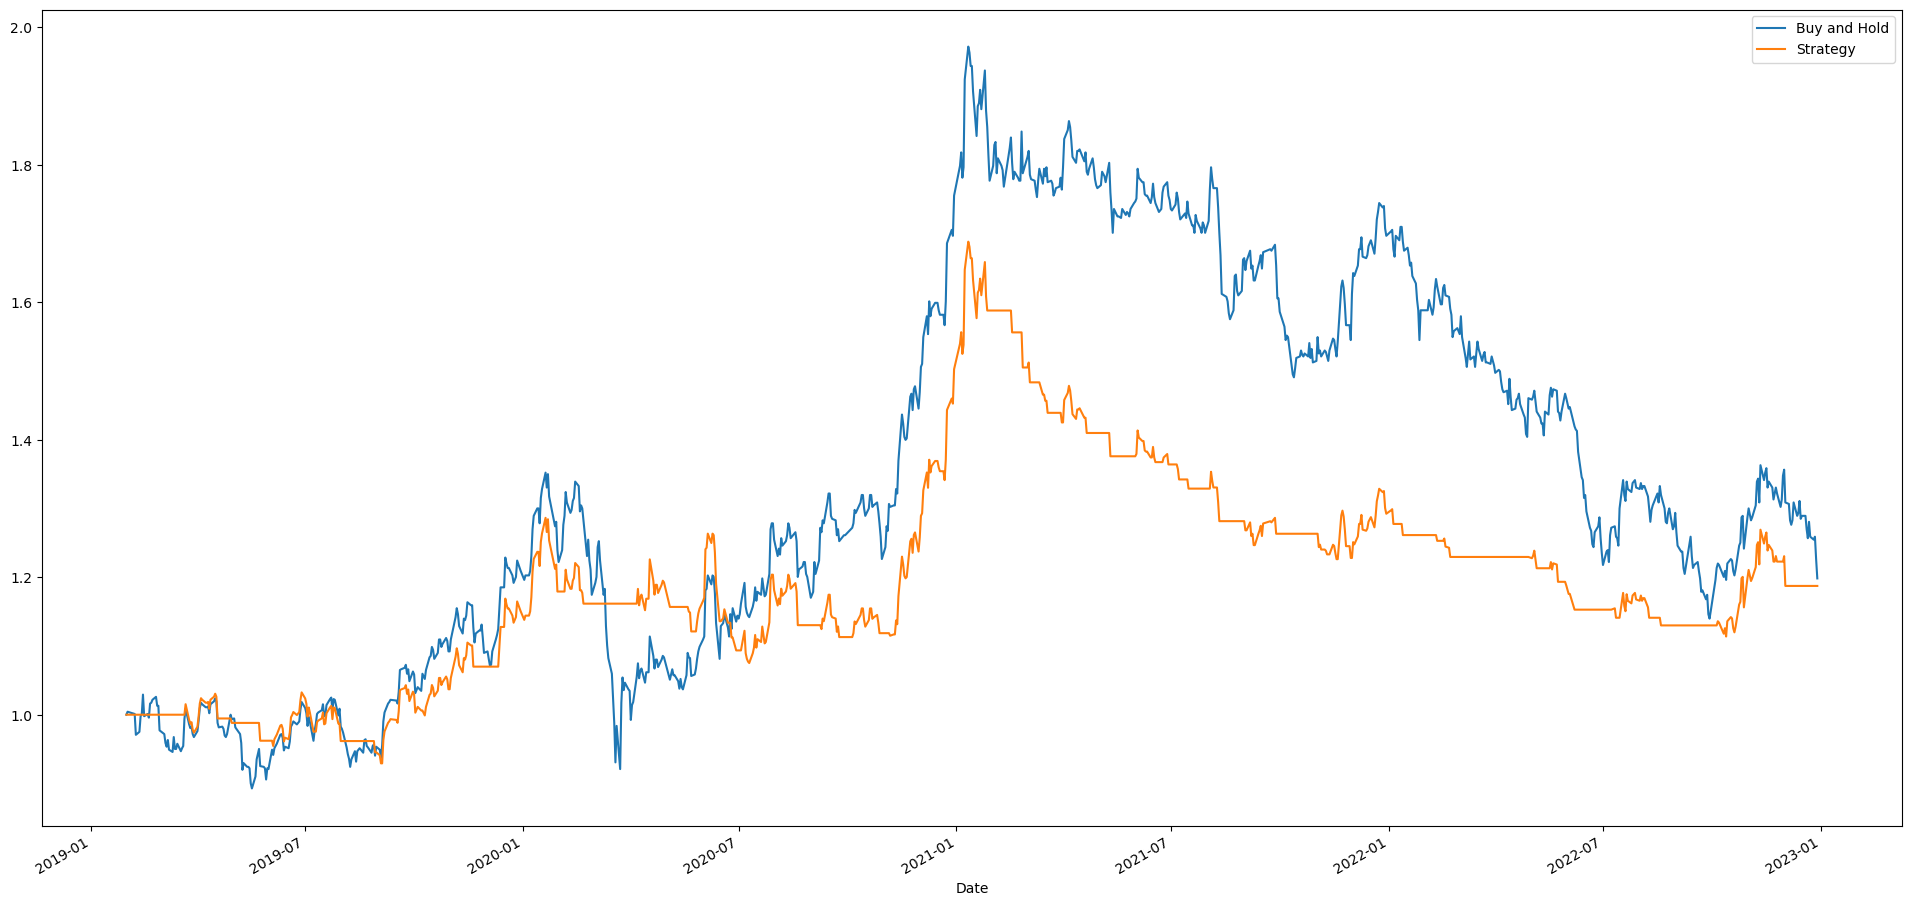

In [77]:
# 전략의 수익을 확인해봅시다 (삼성전자의 Buy&Hold 결과와 비교)
buy_hold = (samsung.rtn.fillna(0) + 1).cumprod()

buy_hold.plot(figsize=(24,12))
result.plot(figsize=(24,12))
plt.legend(["Buy and Hold","Strategy"]); # Legend(범례)를 지정해줄 수 있습니다(순서대로 넣어주면 됨)

## 4. 확률 과정 (Stochastic Process)

### 1. 기하 브라운 운동 모형

BSM 모형을 사용한 미래 특정 시점 T에서의 주가 $S_T$를 현 시점의 주가 $S_0$을 토대로 계산

* BSM 모형의 확률 미분방정식: $dS_t = rS_tdt + \sigma S_t dZ_t$

* BSM 모형을 따르는 주가 시뮬레이션(오일러방식으로 이산화): $S_T = S_{t-\Delta t} \exp((r- {1 \over 2} \sigma^2) \Delta t + \sigma \sqrt {\Delta t} z_t)$

In [78]:
# 파라미터 세팅
S_0 = 100     # 최초 주가
T = 2.0       # 연 단위 만기
r = 0.05      # 무위험 단기 이자율
sigma = 0.25  # 변동성

I = 10000     # 시뮬레이션의 수
M = 50   
dt = T/M  #연 단위 시간 길이
S = np.zeros((M+1, I)) # 주가를 담을 array
S[0] = S_0             # 최초 주가를 설정

In [79]:
# 주가를 어느 방향으로 시뮬레이션 할지 보이시나요?
S

array([[100., 100., 100., ..., 100., 100., 100.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [80]:
S.shape

(51, 10000)

In [81]:
# 시뮬레이션 : 이산화 된 수식에 그대로 넣어주면 된다
for t in range(1, M+1): # M개의 시간동안 진행
    S[t] = S[t-1] * np.exp((r-0.5*sigma**2) * dt + sigma * np.sqrt(dt) * np.random.standard_normal(I))

In [82]:
# 결과
S

array([[100.        , 100.        , 100.        , ..., 100.        ,
        100.        , 100.        ],
       [102.50601523,  90.58234949, 100.34582321, ..., 105.5272958 ,
         95.87783773,  98.99503385],
       [103.09356749,  82.12220079, 107.02206414, ..., 107.11475132,
         96.28993778,  97.1371606 ],
       ...,
       [110.4422721 , 115.98784153,  86.45824945, ..., 134.11773003,
         98.06525052,  85.63563297],
       [ 99.91335195, 120.6625272 ,  81.82948891, ..., 136.85368719,
         96.05754748,  83.49240952],
       [102.01434377, 122.98979041,  74.79899967, ..., 141.68468736,
         95.45984287,  95.32969502]])

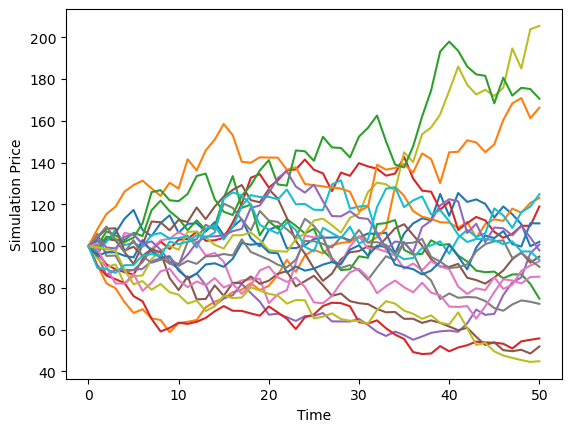

In [85]:
# 10 개의 주가 경로만 시각화
plt.plot(S[:,:20])
plt.xlabel("Time")
plt.ylabel("Simulation Price");

### 2. 제곱근 확산 모형 (Square-Root Diffusion)

평균으로 회귀하는 특징이 있는 단기 이자율이나 변동성 모형에 사용하는 확률 과정

평균 회귀 과정에서 가장 널리 사용되는 모형은 콕스-잉거솔-로스(1985)의 제곱근 확산 모형

제곱근 확산 모형은 $x_t$의 값이 항상 양수로 유지된다는 현실적이고 편리한 특성을 가진다(이자율, 변동성)

하지만, 단순 오일러 방식으로 이산화하면 음수가 될 가능성이 생기기 때문에 원래의 시뮬레이션 값에서 양수만을 취하는 방식을 사용한다

* 확률 미분방정식: $dx_t = \kappa (\theta - x_t)dt + \sigma \sqrt x_t dZ_t$

* 오일러 방식으로 이산화: $\tilde {x}_t = \tilde {x}_s + \kappa (\theta - \tilde {x^{+}}_s) \Delta t + \sigma \sqrt{\tilde {x^{+}}_s} \sqrt{\Delta t} z_t $   $\quad$ where,  $\tilde {x}_t = \tilde {x^+}_s $ 

In [21]:
# 파라미터 셋팅
x0 = 0.05     # (단기 이자울) 초깃값
kappa = 3.0   # 평균 회귀계수
theta = 0.02  # 장기 평균값
sigma = 0.1   # 변동성
T = 2.0
I = 10000   
M = 50
dt = T/M #연 단위 시간 길이

# 시뮬레이션 값을 담을 array 생성
xh = np.zeros((M+1,I))
xh[0] = x0 # 초깃값 셋팅

In [22]:
xh

array([[0.05, 0.05, 0.05, ..., 0.05, 0.05, 0.05],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

In [23]:
# 시뮬레이션
for t in range(1,M+1):
    xh[t] = xh[t-1] + kappa * (theta - np.maximum(xh[t-1], 0)) * dt \
                    + (sigma * np.sqrt(np.maximum(xh[t-1], 0)) * np.sqrt(dt) * np.random.standard_normal(I))
                    
x = np.maximum(xh,0) # 음수값은 0으로 바꾼다

In [25]:
x

array([[0.05      , 0.05      , 0.05      , ..., 0.05      , 0.05      ,
        0.05      ],
       [0.04622957, 0.05098229, 0.04418523, ..., 0.05287055, 0.04204757,
        0.04948276],
       [0.03396839, 0.05091954, 0.04300568, ..., 0.05049178, 0.04645384,
        0.03750184],
       ...,
       [0.020849  , 0.01977019, 0.02706006, ..., 0.01654748, 0.02806188,
        0.01978474],
       [0.01839909, 0.01920201, 0.0237295 , ..., 0.01915342, 0.02787808,
        0.02014646],
       [0.02234635, 0.02586712, 0.02763595, ..., 0.01890531, 0.02800794,
        0.01529081]])

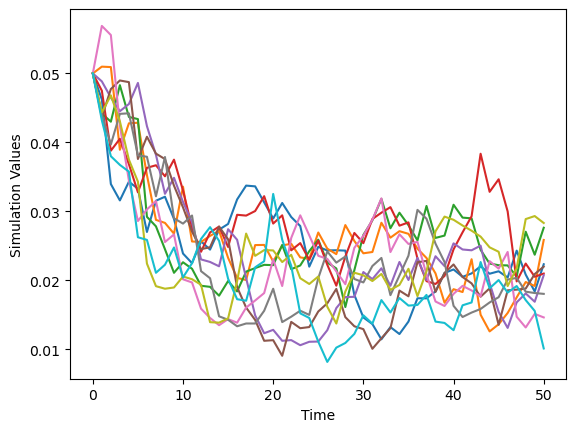

In [26]:
# 10개의 경로만 시각화
plt.plot(x[:,:10])
plt.xlabel("Time")
plt.ylabel("Simulation Values");
# 장기 평균 값으로 수렴하는 것을 확인할 수 있다

### 3. 확률적 변동성 모형 (Stochastic Volatility Model)

BSM 가정의 단점 중 하나인 고정 변동성을 개선, 이 중에 가장 인기 있는 모형인 헤스톤 모형(1993)

---

* $dS_t = r S_t dt + \sqrt v_t S_t Z^1_t$

* $dv_t = \kappa_v (\theta_v - v_t)dt + \sigma_v \sqrt v_t dZ^2_t $

* $dZ^1_t dZ^2_t = \rho$  ->  인수 $\rho$는 두 표준 브라운 운동 $Z^1_t$, $Z^2_t$의 순간 상관계수를 나타낸다

---

상관계수를 통해 시장이 하락할 때 변동성이 증가하고, 시장이 상승할 때 변동성이 감소하는 레버리지 효과를 설명 

두 확률 과정의 상관관계를 구하기 위해선 상관계수 행렬에 대한 숄레스키 분해가 필요하다

In [32]:
# 파라미터 세팅
S0 = 100
r = 0.05
v0 = 0.1    # 초기 순간 변동성 값
kappa = 3.0
theta = 0.25
sigma = 0.1
rho = 0.6   # 두 브라운 운동의 고정 상관계수
T = 1.0

In [33]:
# 두 확률 과정의 상관계수 행렬 구하기
corr_mat = np.zeros((2,2))
corr_mat[0,:] = [1.0, rho]
corr_mat[1,:] = [rho, 1.0]
cho_mat = np.linalg.cholesky(corr_mat)

cho_mat

array([[1. , 0. ],
       [0.6, 0.8]])

In [40]:
# 미분방정식이 두개이기 때문에, 변동성과 주가 각각을 시뮬레이션
# 제곱근 확산 모형에 기반한 변동성 과정을 (상관관계를 고려한) 오일러 이산화 방식을 사용해서 시뮬레이션
M = 50
I = 10_000
dt = T/M

ran_num = np.random.standard_normal((2,M+1,I)) # 난수를 미리 생성

# 변동성의 변화를 담을 array 생성
vh = np.zeros_like(ran_num[0])

# 초기 변동성 셋팅
vh[0] = v0

# 시뮬레이션
for t in range(1,M+1):
    ran = np.dot(cho_mat, ran_num[:, t,:])
    vh[t] = (vh[t-1] + \
             kappa * (theta - np.maximum(vh[t-1], 0)) * dt + \
             sigma * np.sqrt(np.maximum(vh[t-1], 0)) * \
             np.sqrt(dt) * ran[1])
    
v = np.maximum(vh,0)

In [41]:
# 기하 브라운 운동 모형에 기반한 주가과정을 오일러 이산화 방식을 사용해서 시뮬레이션
S = np.zeros_like(ran_num[0])
S[0] = S0

for t in range(1,M+1):
    ran = np.dot(cho_mat, ran_num[:,t,:])
    S[t] = S[t-1] * np.exp((r-0.5 * v[t]) * dt + \
                    np.sqrt(v[t]) * ran[0] * np.sqrt(dt))

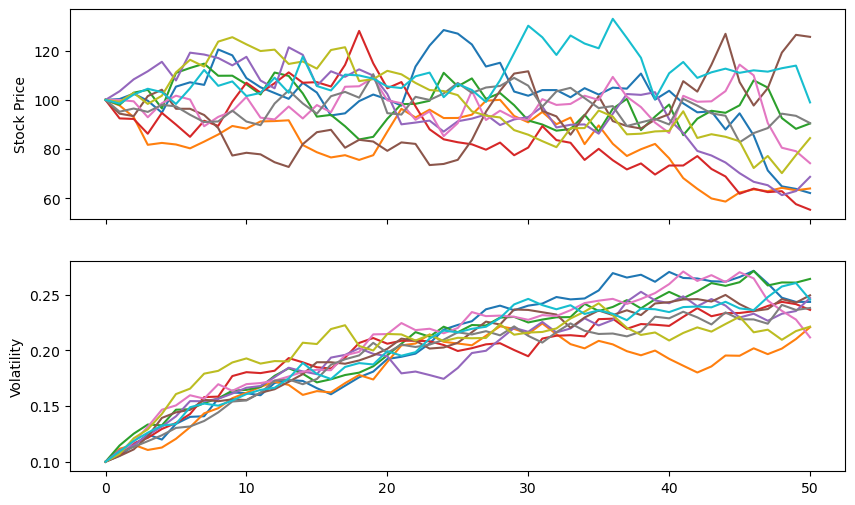

In [42]:
fig, (ax1, ax2) = plt.subplots(2,1,
                               sharex=True,
                               figsize=(10,6))

ax1.plot(S[:, :10])
ax1.set_ylabel("Stock Price")

ax2.plot(v[:, :10])
ax2.set_ylabel("Volatility");

## 5. 옵션 가치평가: 유러피안 옵션

유러피안 콜 옵션의 만기 페이오프는 $h(S_T) \equiv$ MAX $(S_T - K, 0)$

몬테카를로 방식으로 주가를 시뮬레이션 하여 옵션 가격을 추정할 수 있다

* $ \tilde {C_0} = e^{-rT} {1 \over I} \displaystyle\sum_{i=1}^{I} h(\tilde {S^i_T})$

앞서 배운 기하-브라운 모형으로 $S_T$를 시뮬레이션해서, 그 값을 위 식에 넣으면 된다

In [87]:
# 초기값 세팅

S0 = 100
r = 0.05
sigma = 0.25
T = 1.0
I = 50_000  
M = 50      #이산화 시간 구간의 개수
dt = T / M 

In [88]:
option = "call" # or "put"
K = 110    # 행사가

In [89]:
# 시뮬레이션
S = np.zeros((M+1, I))
S[0] = S0

sn = np.random.standard_normal((M+1,I))

for t in range(1,M+1):
    S[t] = S[t-1] * np.exp((r-0.5 * sigma ** 2) * dt \
                           + sigma * np.sqrt(dt) * sn[t])

# 페이오프 함수에 집어 넣기
if option == "call":
    hT = np.maximum(S[-1] - K, 0)
else: # 풋 옵션인 경우...
    hT = np.maximum(K - S[-1], 0)

# 시뮬레이션 값 계산
C0 = np.exp(-r * T) * np.mean(hT)

C0

7.999438938115067